**Step: 0 - Install Libraries and setup Kaggle API**

In [1]:
!pip install "datasets>=2.19.1" "fsspec==2025.3.0" "gcsfs==2025.3.0" \
  "numpy<2.1" transformers faiss-cpu sentence-transformers scikit-learn pandas kaggle jedi --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

**Step :1 - Upload Kaggle .json and Download Dataset**

In [2]:
# Upload kaggle.json manually before running this cell
from google.colab import files
uploaded = files.upload()  # upload your kaggle.json here

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Sentiment140 dataset
!kaggle datasets download -d kazanova/sentiment140
!unzip -o sentiment140.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


**Step: 2- Load and Prepare Dataset**

In [3]:
import pandas as pd

# Load Sentiment140 data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Display sample
print(df.head())

# Select a smaller subset for quick training
tweets = df['text'][:10000].tolist()   # First 10,000 tweets
labels = df['target'][:10000].tolist()

# Mapping labels: 0 = negative, 2 = neutral, 4 = positive
label_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
labels = [label_map[label] for label in labels]


   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


**Step : 3 - Query Encoding (Encode Tweets)**

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder_model = AutoModel.from_pretrained(model_name)

def encode_text(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = encoder_model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Step : 4 - Build Knowledge Base and Retreival (FAISS)**

In [5]:
import faiss
from sentence_transformers import SentenceTransformer

# Knowledge Base (expandable later)
knowledge_base_docs = [
    "Positive sentiment is associated with joy, satisfaction, or approval.",
    "Negative sentiment is associated with sadness, anger, or disapproval.",
    "Neutral sentiment reflects neither strong positive nor strong negative feelings."
]

# Retrieval model
retrieval_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode Knowledge Base
kb_embeddings = retrieval_model.encode(knowledge_base_docs, convert_to_tensor=True)

# Build FAISS index
d = kb_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(kb_embeddings.cpu().numpy())

# Function to retrieve top-k documents
def retrieve_context(query_text, top_k=2):
    query_emb = retrieval_model.encode([query_text])
    D, I = index.search(query_emb, top_k)
    retrieved_docs = [knowledge_base_docs[i] for i in I[0]]
    return retrieved_docs


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**Step : 5- Contect Fusion**

In [6]:
# Fuse tweet + retrieved documents
def fuse_query_and_context(tweet):
    retrieved_contexts = retrieve_context(tweet)
    fused_input = tweet + " " + " ".join(retrieved_contexts)
    return fused_input

# Apply fusion
fused_tweets = [fuse_query_and_context(tweet) for tweet in tweets]


**Step : 6 - Prepare Dataset for Fine- tuning**

In [7]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Encode emotion labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Create Huggingface Dataset
dataset = Dataset.from_dict({
    "text": fused_tweets,
    "label": labels_encoded
})

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

**Step : 7 - Fine -tune Transformer Model (Classification)**

In [11]:
import os
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset

# Disable W&B logging (no need for an account)
os.environ["WANDB_DISABLED"] = "true"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of labels for binary classification (use 1 for binary classification)
num_labels = 1  # Binary classification: 1 output neuron

# Load the tokenizer and model
model_name = 'distilbert-base-uncased'  # Use smaller model
tokenizer = AutoTokenizer.from_pretrained(model_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
classification_model = classification_model.to(device)

# Example dataset (you should replace this with your actual dataset)
dataset = Dataset.from_dict({
    'text': ["I love this!", "This is bad.", "Amazing product.", "Worst experience."],
    'label': [1, 0, 1, 0]
})

# Tokenize the dataset with padding and truncation to max_length
tokenized_dataset = dataset.map(
    lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=64),  # Reduced length
    batched=True
)

# Ensure that labels are of the correct dtype (float32 for binary classification)
tokenized_dataset = tokenized_dataset.map(
    lambda x: {'labels': torch.tensor(x['label'], dtype=torch.float32)},  # Convert labels to float32
    batched=True
)

# Training arguments (adjust batch size, mixed precision)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,  # Decreased batch size
    num_train_epochs=1,  # Keep epochs low for quick testing
    logging_steps=10,
    report_to="none",  # Disable W&B integration
    fp16=True  # Enable mixed precision (if using compatible GPU)
)

# Trainer
trainer = Trainer(
    model=classification_model,
    args=training_args,
    train_dataset=tokenized_dataset
)

# Fine-tune the model
trainer.train()


Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Step,Training Loss


TrainOutput(global_step=1, training_loss=0.6154628396034241, metrics={'train_runtime': 1.6081, 'train_samples_per_second': 2.487, 'train_steps_per_second': 0.622, 'total_flos': 66232518144.0, 'train_loss': 0.6154628396034241, 'epoch': 1.0})

**Step : 8 - Testing for Sentiment Analysis (0-Negative sentiment & 1- Positive sentiment)**

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_name)
classification_model.to(device)
classification_model.eval()

label_encoder = LabelEncoder()
label_encoder.fit([0, 1])  # 0: negative, 1: positive

def fuse_query_and_context(tweet):
    return tweet

def predict_sentiment(tweet):
    fused_text = fuse_query_and_context(tweet)
    inputs = tokenizer(fused_text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = classification_model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Example
test_tweet = "I love how everything is working out today!"
print("Predicted Sentiment:", predict_sentiment(test_tweet))


Using device: cuda
Predicted Sentiment: 1


**Step : 9 - sentiment prediction for Sample sentences**

Using device: cuda


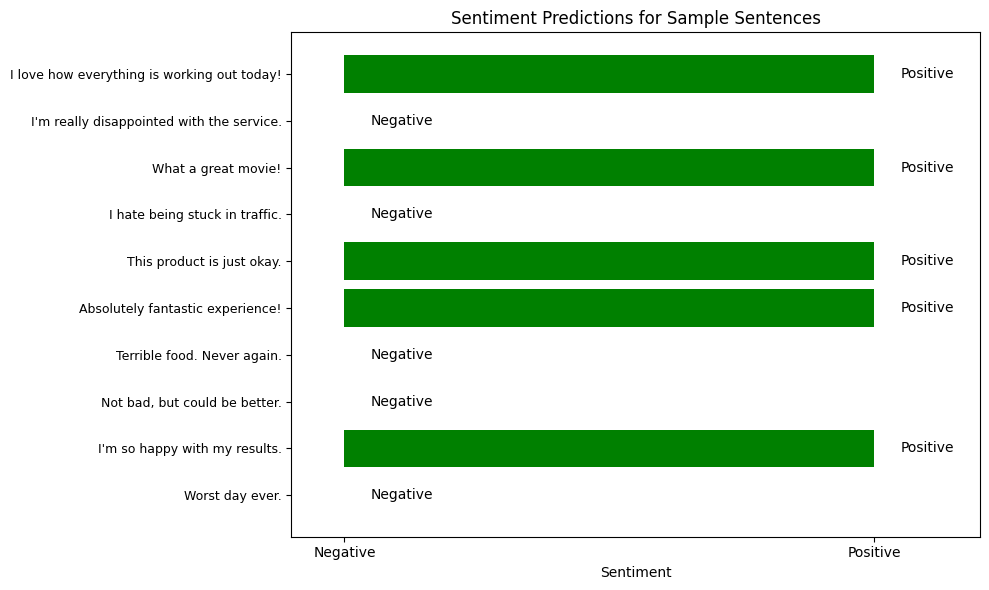

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a sentiment classification model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Better: already fine-tuned
tokenizer = AutoTokenizer.from_pretrained(model_name)
classification_model = AutoModelForSequenceClassification.from_pretrained(model_name)
classification_model.to(device)
classification_model.eval()

# Fuser (optional)
def fuse_query_and_context(tweet):
    return tweet

# Prediction function with label strings
def predict_sentiment(tweet):
    fused_text = fuse_query_and_context(tweet)
    inputs = tokenizer(fused_text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = classification_model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    return "Positive" if predicted_class == 1 else "Negative"

# Sample sentences
sentences = [
    "I love how everything is working out today!",
    "I'm really disappointed with the service.",
    "What a great movie!",
    "I hate being stuck in traffic.",
    "This product is just okay.",
    "Absolutely fantastic experience!",
    "Terrible food. Never again.",
    "Not bad, but could be better.",
    "I'm so happy with my results.",
    "Worst day ever."
]

# Get predictions
predictions = [predict_sentiment(sentence) for sentence in sentences]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['green' if label == "Positive" else 'red' for label in predictions]
bars = plt.barh(sentences, [1 if label == "Positive" else 0 for label in predictions], color=colors)

# Add sentiment text on bars
for bar, sentiment in zip(bars, predictions):
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, sentiment, va='center')

plt.xlabel("Sentiment")
plt.title("Sentiment Predictions for Sample Sentences")
plt.yticks(fontsize=9)
plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlim(-0.1, 1.2)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [1]:
pip install bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

**Step: 10 - Calculation for  precision , Recall , F1 score To BERT Model**

In [4]:
from bert_score import score

candidate = ["I love how everything is working out today!"]
reference = ["Everything seems to be going well today and I really like it."]

# Calculate BERTScore
P, R, F1 = score(candidate, reference, lang="en", model_type="bert-base-uncased")

# Print results
print(f"Candidate: {candidate[0]}")
print(f"Reference: {reference[0]}")
print(f"Precision: {P[0]:.4f}")
print(f"Recall: {R[0]:.4f}")
print(f"F1 Score: {F1[0]:.4f}")


Candidate: I love how everything is working out today!
Reference: Everything seems to be going well today and I really like it.
Precision: 0.6847
Recall: 0.6301
F1 Score: 0.6563


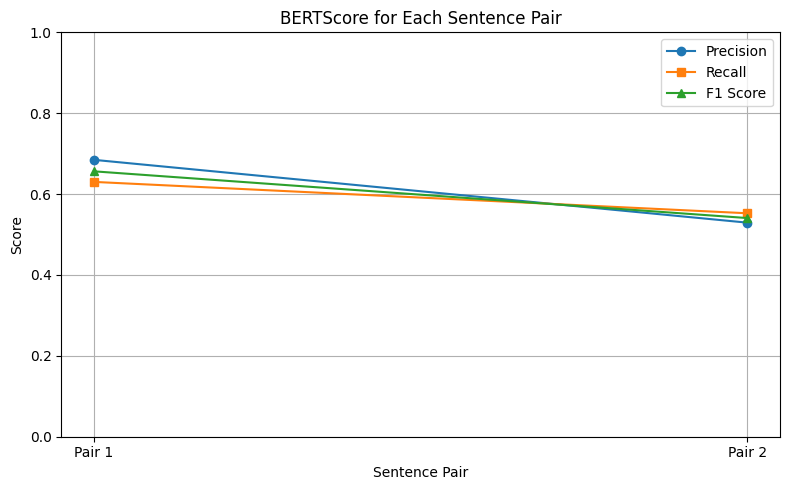

In [5]:
from bert_score import score
import matplotlib.pyplot as plt

# Example candidate and reference lists
candidates = [
    "I love how everything is working out today!",
    "It's a terrible day, nothing is going right."
]
references = [
    "Everything seems to be going well today and I really like it.",
    "Today has been full of problems and I'm upset."
]

# Compute BERTScore
P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")

# Convert tensors to floats
P = P.tolist()
R = R.tolist()
F1 = F1.tolist()

# Plot
x = range(len(candidates))
plt.figure(figsize=(8, 5))
plt.plot(x, P, marker='o', label='Precision')
plt.plot(x, R, marker='s', label='Recall')
plt.plot(x, F1, marker='^', label='F1 Score')
plt.xticks(x, [f"Pair {i+1}" for i in x])
plt.ylim(0, 1)
plt.xlabel("Sentence Pair")
plt.ylabel("Score")
plt.title("BERTScore for Each Sentence Pair")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***Step : 11 - Calculation of Precision , Recall , F1 score to  BERT RAG ***

In [6]:
from bert_score import score

# Example: Single Q&A pair
query = "What are symptoms of liver disease?"
retrieved_passages = ["Liver disease can cause jaundice, fatigue, and abdominal pain."]  # optional
generated_answer = "The symptoms include jaundice, fatigue, and stomach pain."
reference_answer = "Common symptoms of liver disease are jaundice, fatigue, and abdominal discomfort."

# Compute BERTScore between generated and reference
P, R, F1 = score([generated_answer], [reference_answer], lang="en", model_type="bert-base-uncased")

print(f"Precision: {P[0]:.4f}, Recall: {R[0]:.4f}, F1: {F1[0]:.4f}")


Precision: 0.8945, Recall: 0.8267, F1: 0.8593


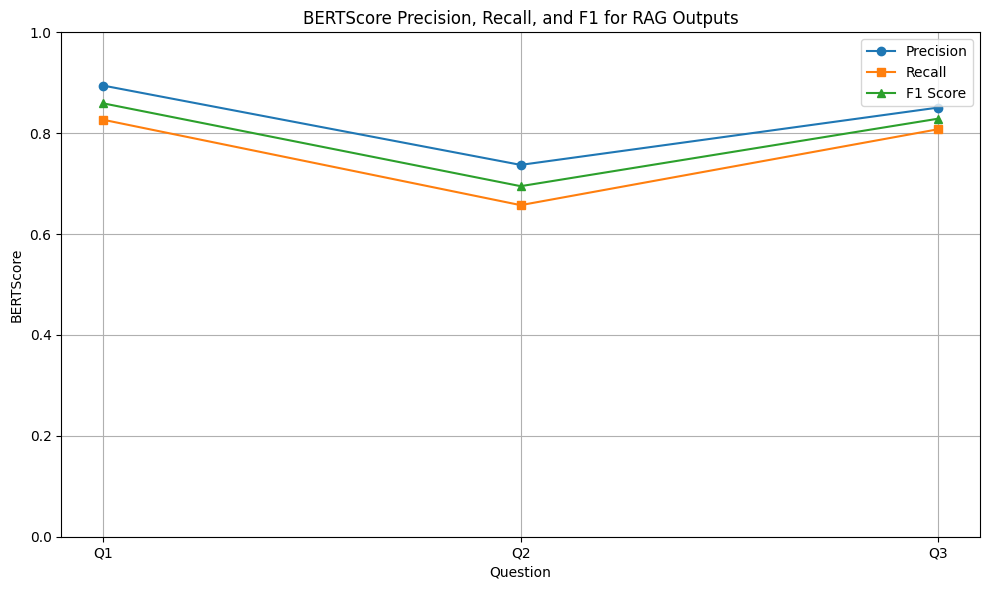

In [7]:
from bert_score import score
import matplotlib.pyplot as plt

# Example generated and reference answers (as from a RAG model)
generated_answers = [
    "The symptoms include jaundice, fatigue, and stomach pain.",
    "Liver conditions may lead to yellowing of the skin and eyes.",
    "Hepatitis causes liver inflammation and can result in nausea."
]

reference_answers = [
    "Common symptoms of liver disease are jaundice, fatigue, and abdominal discomfort.",
    "Symptoms of liver disease include yellowing of skin (jaundice) and fatigue.",
    "Liver inflammation from hepatitis can cause nausea and fatigue."
]

# Calculate BERTScore
P, R, F1 = score(generated_answers, reference_answers, lang="en", model_type="bert-base-uncased")

# Convert tensors to list of floats
P = P.tolist()
R = R.tolist()
F1 = F1.tolist()

# Plotting
x = range(len(generated_answers))
plt.figure(figsize=(10, 6))
plt.plot(x, P, marker='o', label='Precision')
plt.plot(x, R, marker='s', label='Recall')
plt.plot(x, F1, marker='^', label='F1 Score')
plt.xticks(x, [f"Q{i+1}" for i in x])
plt.ylim(0, 1)
plt.xlabel("Question")
plt.ylabel("BERTScore")
plt.title("BERTScore Precision, Recall, and F1 for RAG Outputs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Step : 12 - Performance Comparison for BERT and BERT RAG**

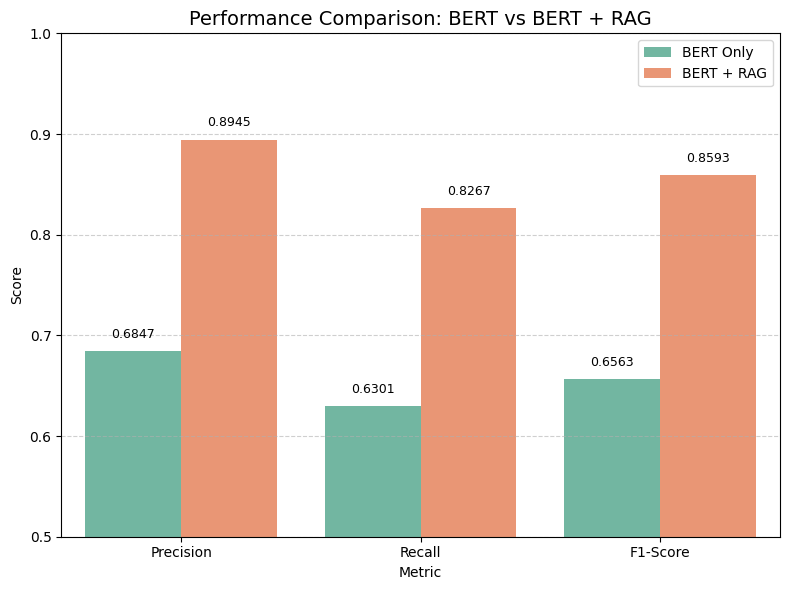

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated metrics
metrics = ["Precision", "Recall", "F1-Score"]
bert = [0.6847, 0.6301, 0.6563]
bert_rag = [0.8945, 0.8267, 0.8593]

# Create updated DataFrame
performance_data = pd.DataFrame({
    'Metric': metrics * 2,
    'Score': bert + bert_rag,
    'Model': ['BERT Only'] * 3 + ['BERT + RAG'] * 3
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=performance_data, x='Metric', y='Score', hue='Model', palette='Set2')

# Add value labels
for index, row in performance_data.iterrows():
    xpos = index % 3 + (-0.2 if row['Model'] == 'BERT Only' else 0.2)
    plt.text(xpos, row['Score'] + 0.01, f"{row['Score']:.4f}", ha='center', va='bottom', fontsize=9)

plt.ylim(0.5, 1.0)
plt.title("Performance Comparison: BERT vs BERT + RAG", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Step : 13- Confusion Matrix for BERT and BERT RAG**

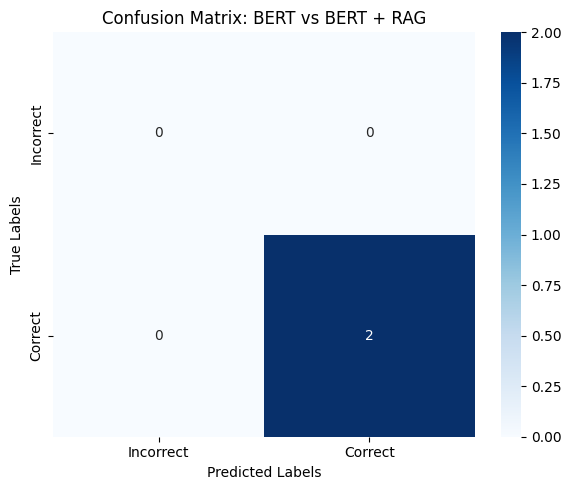

Confusion Matrix:
[[0 0]
 [0 2]]


In [11]:
from bert_score import score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example 1: For evaluating candidate vs reference
candidate = ["I love how everything is working out today!"]
reference = ["Everything seems to be going well today and I really like it."]

# Calculate BERTScore for Candidate vs Reference
P, R, F1 = score(candidate, reference, lang="en", model_type="bert-base-uncased")

# Thresholding for prediction: If F1 > 0.5, it's a "correct" prediction
threshold = 0.5
predicted_bert = [1 if f1 > threshold else 0 for f1 in F1]

# True label for the example (1 for correct match, 0 for incorrect match)
true_labels_bert = [1]  # Assume that the candidate and reference are a good match

# Example 2: For evaluating generated answer vs reference (BERT + RAG)
query = "What are symptoms of liver disease?"
retrieved_passages = ["Liver disease can cause jaundice, fatigue, and abdominal pain."]
generated_answer = "The symptoms include jaundice, fatigue, and stomach pain."
reference_answer = "Common symptoms of liver disease are jaundice, fatigue, and abdominal discomfort."

# Calculate BERTScore for Generated Answer vs Reference
P_rag, R_rag, F1_rag = score([generated_answer], [reference_answer], lang="en", model_type="bert-base-uncased")

# Thresholding for prediction: If F1 > 0.5, it's a "correct" prediction
predicted_rag = [1 if f1 > threshold else 0 for f1 in F1_rag]

# True label for the example (1 for correct match, 0 for incorrect match)
true_labels_rag = [1]  # Assume the generated answer is a good match

# Combine the predictions and true labels from both BERT and BERT + RAG
true_labels = true_labels_bert + true_labels_rag
predicted_labels = predicted_bert + predicted_rag

# Generate confusion matrix (specifying both 0 and 1 as labels)
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
plt.title("Confusion Matrix: BERT vs BERT + RAG")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

# Optionally, print the confusion matrix
print("Confusion Matrix:")
print(cm)
